# Исследование объявлений о продаже квартир

<a id='Описание'></a>
В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

**Цель исследования**

Провести исследовательский анализ данных и установить параметры, влияющие на цену объектов. 


**Краткий план работы**

1. Выполнить предобработку данных

2. Добавить в таблицу новые столбцы со следующими параметрами:
- цена одного квадратного метра;
- день недели публикации объявления;
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры;
- расстояние до центра города в километрах.

3. Исследовательский анализ данных:
- Изучить параметры объектов и построить гистограммы
- Изучить, как быстро продавались квартиры
- Определить факторы, которые больше всего влияют на общую (полную) стоимость объекта.
- Посчитать среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.
- Вычислить среднюю стоимость квартир в Санкт-Петербурге на разном удалении от центра.

4. Описать полученные результаты и зафиксировать итоговый вывод проведённого исследования.

### Открываем файл с данными и изучаем общую информацию

In [18]:
#импорт библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
pd.options.mode.chained_assignment = None

In [2]:
#загрузка данных
data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [3]:
#проверяем данные
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
#изучаем общую информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Сразу можем отметить типы данных, которые стоит изменить:

- **first_day_exposition** object на datetime
- **is_apartment** object на bool

Количество объектов не может быть вещественным числом, поэтому:
- **floors_total** float на int
- **balcony** float на int
- **days_exposition**  float на int

In [5]:
#посмотрим количество пропусков
data.isna().sum().sort_values()

total_images                0
open_plan                   0
floor                       0
rooms                       0
studio                      0
total_area                  0
last_price                  0
first_day_exposition        0
locality_name              49
floors_total               86
living_area              1903
kitchen_area             2278
days_exposition          3181
ponds_around3000         5518
parks_around3000         5518
cityCenters_nearest      5519
airports_nearest         5542
ceiling_height           9195
balcony                 11519
ponds_nearest           14589
parks_nearest           15620
is_apartment            20924
dtype: int64

**Рассмотрим пропуски в данных, которые заполнялись в ручную**

- **locality_name** количество пропусков незначительное, удаление этих строк допустимо
- **floors_total** количество пропусков незначительное, удаление этих строк допустимо
- **living_area** и **kitchen_area** заполнить эти пропуски средним значением некорректно, оставим как есть.
- **ceiling_height** можем заполнить средним значением.
- **balcony** скорее всего пропуски говорят об отсутствии балконов, заменим их на 0
- **is_apartment** Апартаменты не самый частый вид недвижимости. Можем предположить, что отсутвие значений
ровно False, так и заменим, но при анализе будем учитывать, что данные могут быть неточны. 

**Рассмотрим пропуски в данных, которые заполнялись автоматически**

**airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest** 

Столбцы с данными о расстоянии до объектов содержат достаточно пропусков. Данные либо невыгружены из-за технической ошибки, либо присутсвует закономерность и, например, для определенных населенных пунктов эти данные не заполняются. 
В любом случае в ручную мы не сможем подобрать точные данные для заполнения этих пропусков. 
Строк с заполненными значениями достаточно, чтобы проследить тенденции и провести исследования.

#### Изучим количественные данные

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

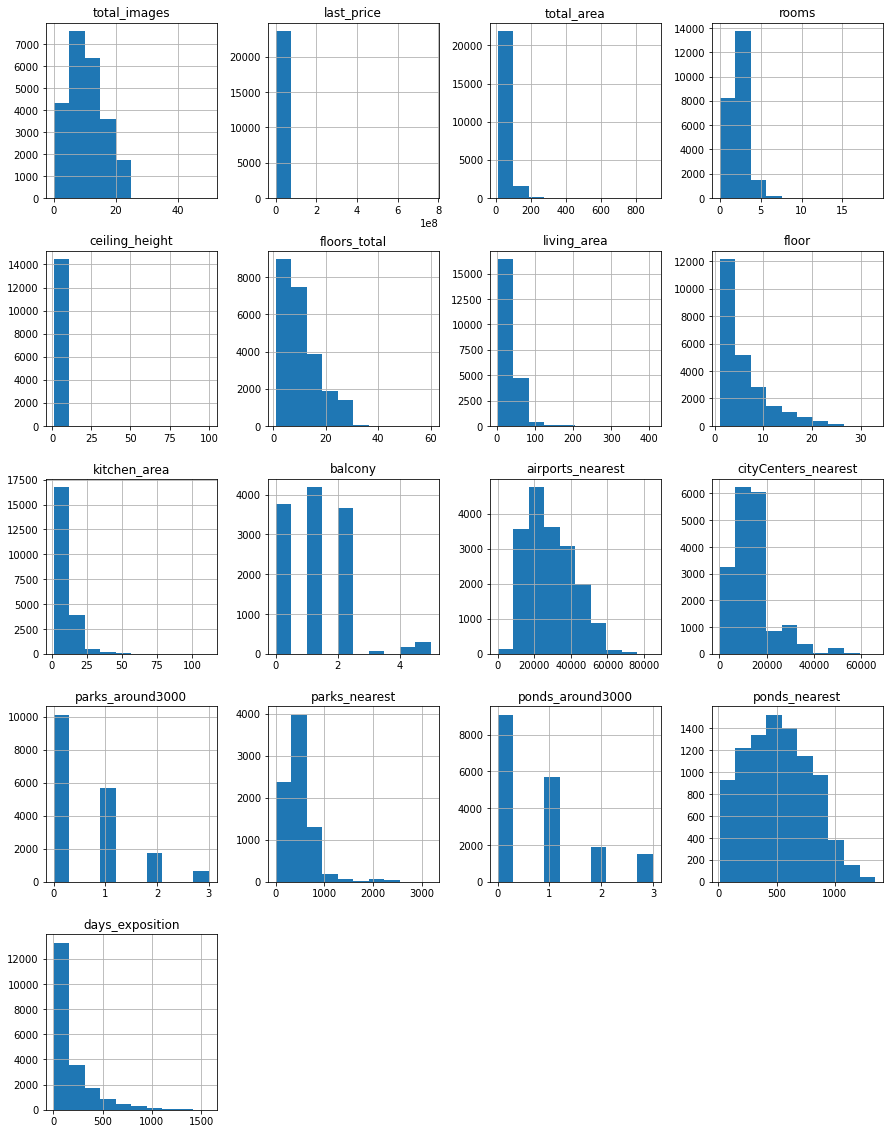

In [6]:
#построим гистограммы количественных параметров
data.hist(figsize=(15, 20))

Посмотрим подробную информацию о всех значениях

In [8]:
#посмотрим подробную информацию количественных значений
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Можем заметить аномальные значения (например 0 комнат и 100 метровые потолки), в дальнейшем разберем эти данные подробнее и при необходимости избавимся от выбросов.

#### Вывод

1. Объем датасета составляет 23699 строки в 22 столбца. Количества данных достаточно для проведения исследования.  

2. Значения в датасете имеют разные типы данных ( числовые, булевые и текстовые). Наиболее представленными значениями в датасете являются числовые вещественные.  

3. Проведя разведочный анализ данных, можно отметить, что датасет имеет выбросы и  определенное количество пропусков. Наличие пропусков в данных, которые затруднительно заполнить релевантыми значениями, не повлияют на ход иследования. Остальные пропущенные значения возможно заменить или удалить без потери качества информации.  

Для дальнейшей работы данный этап вывел следующие необходимые шаги:


- изменить некорректные типы данных
- удалить строки с пропусками, где их количество не критично
- изучить явные и неявные дубли
- для удобства необходимо добавить некоторые категории данных

### Предобработка данных


#### Названия населенных пунктов 

In [6]:
#удаляем пропуски 
data = data.dropna(subset=['locality_name'])
data['locality_name'].isnull().sum()

0

In [7]:
#посмотрим общее количество уникальных значений
len(data['locality_name'].unique())

364

In [8]:
sorted(data['locality_name'].unique())

['Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское',
 'городск

При быстром просмотре видим одинаковые названия с 'е' и 'ё'.

Так же есть населенные пункты у которых тип населенного пункта один и тот же, но записан по разному.  
Например поселок Рябово и поселок городского типа Рябово.

In [9]:
#удаляем дубли с е и ё
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)
len(data['locality_name'].unique())

330

In [10]:
#удаляем неявные дубликаты
replacements = {'поселок Рябово ': ' поселок городского типа Рябово',
                 'городской поселок Большая Ижора ': ' поселок городского типа Большая Ижора',
                'городской поселок Лесогорский': 'поселок городского типа Лесогорский',
                'городской поселок Назия': 'поселок городского типа Назия',
                'городской поселок Рощино': 'поселок городского типа Рощино',
                'городской поселок Советский': 'поселок городского типа Советский',
                'поселок при железнодорожной станции Вещево': 'поселок станции Вещево',
                'поселок при железнодорожной станции Приветнинское': 'поселок станции Приветнинское'
                 }

data['locality_name'] = data['locality_name'].replace(replacements, regex=True)

len(data['locality_name'].unique())

324

Удалили 30 дублей в названиях городов и избавились от пустых строк

Добавим небольшую разбивку для дальнейшей работы. Выделим город и лен область, создав соответсвующий столбец.

In [12]:
data['is_spb'] = (data['locality_name'] == 'Санкт-Петербург')

In [13]:
#посмотрим на количество получившихся значений
data['is_spb'].value_counts()

True     15721
False     7929
Name: is_spb, dtype: int64

#### Апартаменты

In [14]:
#заменяем пропуски на 0
data['is_apartment'] = data['is_apartment'].fillna(False)
#меняем тип данных
data['is_apartment'] = data['is_apartment'].astype('bool')
data['is_apartment'].isnull().sum()

0

#### Балконы

In [15]:
#заменяем пропуски на 0
data['balcony'] = data['balcony'].fillna(0)
#меняем тип данных
data['balcony'] = data['balcony'].astype('int')
data['balcony'].isnull().sum()

0

#### Дата публикации

In [16]:
#меняем тип данных, убирая время (оно нам не понадобится)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

#### Всего этажей в доме

In [19]:
#удаляем пропуски 
data = data.dropna(subset=['floors_total'])
#меняем тип данных
data['floors_total'] = data['floors_total'].astype('int')

data['floors_total'].isnull().sum()

0

#### Высота потолков

In [20]:
#выведем уникальные значения столбца
sorted(data['ceiling_height'].unique())

[1.0,
 2.0,
 2.3,
 2.4,
 2.45,
 2.46,
 2.48,
 2.53,
 2.59,
 2.62,
 2.63,
 2.7,
 nan,
 1.2,
 1.75,
 2.2,
 2.25,
 2.34,
 2.47,
 2.49,
 2.5,
 2.51,
 2.52,
 2.54,
 2.55,
 2.56,
 2.57,
 2.58,
 2.6,
 2.61,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.62,
 3.63,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.75,
 3.76,
 3.78,
 3.8,
 3.82,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,
 3.9,
 3.93,
 3.95,


count    14481.000000
mean         2.771283
std          1.261983
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

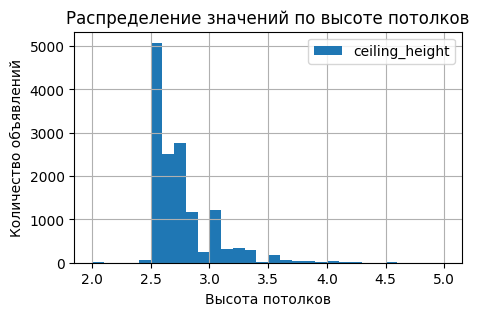

In [21]:
#посмотрим на распределение значений
data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,5), grid=True, figsize = (5,3))
plt.title('Распределение значений по высоте потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Количество объявлений')
data['ceiling_height'].describe()

Мы видим, что большинство значений находятся в диапазоне от 2,5 до 3,5. 
Мы можем предположить, что аномальные значения от 25 вызваны ошибкой в запятой, попробуем их исправить.

In [22]:
data.loc[data['ceiling_height'] >= 24, 'ceiling_height'] = data['ceiling_height'] / 10 
sorted(data['ceiling_height'].unique())

[1.0,
 1.2,
 1.75,
 2.0,
 2.2,
 2.25,
 2.7,
 nan,
 2.3,
 2.34,
 2.4,
 2.45,
 2.46,
 2.47,
 2.48,
 2.49,
 2.5,
 2.51,
 2.52,
 2.53,
 2.54,
 2.55,
 2.56,
 2.57,
 2.58,
 2.59,
 2.6,
 2.61,
 2.62,
 2.63,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.62,
 3.63,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.75,
 3.76,
 3.78,
 3.8,
 3.82,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,
 3.9,
 3.93,
 3.95,


In [23]:
#заменим пропуски медианой
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['ceiling_height'].describe()

count    23565.000000
mean         2.700373
std          0.306280
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         22.600000
Name: ceiling_height, dtype: float64

0

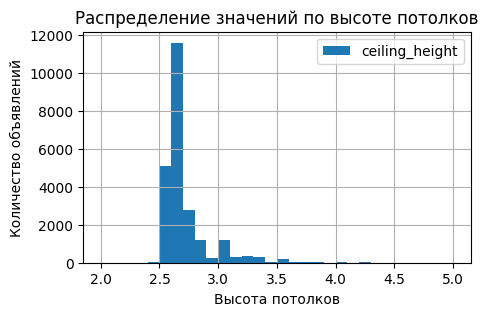

In [24]:
#проверим изменения
data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,5), grid=True, figsize = (5,3))
plt.title('Распределение значений по высоте потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Количество объявлений')
data['floors_total'].isnull().sum()

#### Сколько дней было размещено объявление 

In [25]:
data['days_exposition'].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Посмотрим на колличество пропусков в процентах.

In [26]:
display((data['days_exposition'].isna()).mean() * 100)

13.456397199236156

Доля пропущенных значений небольшая.  

Пропущенные значения в этом столбце означают, что объект еще не продан, поэтому оставим эти значения как есть.

#### Вывод

В результате проведения предобработки датасета удалось улучшить качество данных и подготовить их для дальнейшего анализа и обработки. Были выполнены следующие действия:


    
    - изменили тип данных, где это необходимо
    - заменили пропущенные значения, на подходящие там, где это возможно
    - удалили неявные дубликаты в столбце с названием населенного пункта
    - добавили новый столбец, разделяющий квартиры из Санкт-Петербурга и ЛО
    - исправили аномальные значения в столбце с высотой потолков


### Добавляем новые столбцы

#### Цена одного квадратного метра

In [27]:
#делим стоимость на общую площадь
data['price_sq_meter'] = (data['last_price'] / data['total_area']).round(2)

#### День недели публикации объявления

In [28]:
data['weekday'] = data['first_day_exposition'].dt.weekday

#### Месяц публикации объявления

In [29]:
data['month'] = data['first_day_exposition'].dt.month

#### Год публикации объявления

In [30]:
data['year'] = data['first_day_exposition'].dt.year

#### Тип этажа квартиры

In [31]:
#напишем функцию
def floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

data['type_floor'] = data.apply(floor, axis=1) 

#### Расстояние до центра города в километрах

In [32]:
#переименуем столбец
data.rename(columns={'cityCenters_nearest': 'city_centers_m'}, inplace=True)

#добавим новый столбец со значениями в км
data['city_centers_km'] = (data['city_centers_m'] / 1000).round(0)

#### Вывод

На данном этапе мы уточнили некоторые значения и добавили разбивку по категориям, создав столбцы со следующими данными:
    
    - цена за один квадратный метр
    - день недели публикации
    - месяц публикации
    - год публикации
    - тип этажа квартиры
    - расстояние до центра города в километрах

### Исследовательский анализ данных
<a id='Анализ'></a>

#### Изучение параметров
<a id='Параметры'></a>

**Задачи**

- Изучим  параметры объектов 
- Построим отдельные гистограммы для каждого из этих параметров
- Убирем аномальные и редкие значения в столбцах

##### Общая площадь 

In [33]:
data['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

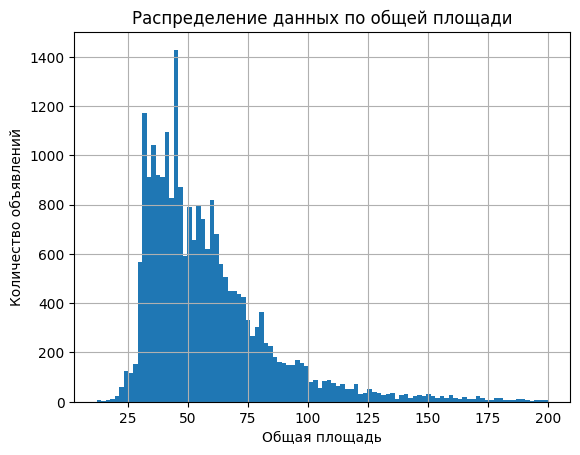

In [34]:
data['total_area'].hist(bins=100, range=(12,200))
plt.title('Распределение данных по общей площади')
plt.xlabel('Общая площадь')
plt.ylabel('Количество объявлений')
plt.show()

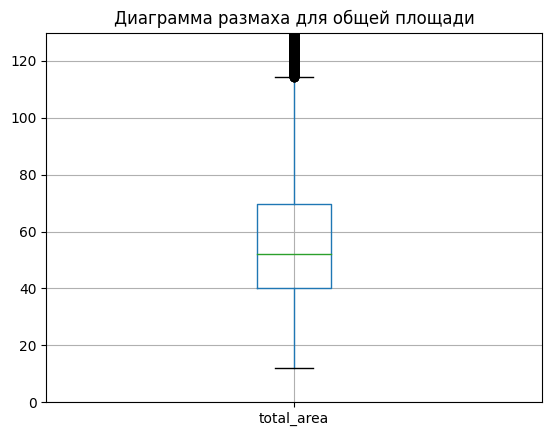

In [35]:
data.boxplot('total_area')
plt.title('Диаграмма размаха для общей площади')
plt.ylim(0, 130)
plt.show()

Среднее значение немногим больше медианы, значит выбивающиеся значения не сильно влияют на данные.

Однако значения выше 120 предлагаю выделить как слишком большие квартиры.

При необходимости мы сможем обратиться к данным, которые отображают большинство значений.

Создадим столбец ['normal_total_area'], где значение True будет для площадей до 120 кв м.

In [36]:
data['normal_total_area'] = data['total_area'] < 120

In [37]:
data['normal_total_area'].value_counts()

True     22474
False     1091
Name: normal_total_area, dtype: int64

Большинство объявлений на продажу квартир с площадью от 30 до 65 кв.м. 
Чаще всего продают квартиры площадью до 120 кв.м.


В данном столбце аномалии не выявлены. Редковстречающиеся значения мы отфильтровали.

##### Жилая площадь

In [38]:
data['living_area'].describe()

count    21700.000000
mean        34.454822
std         22.045359
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

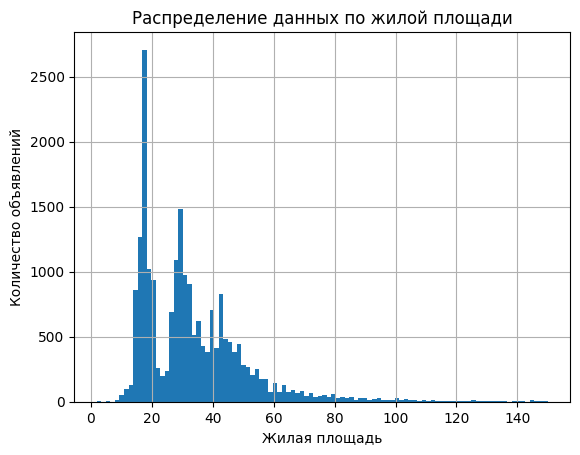

In [39]:
data['living_area'].hist(bins=100, range=(2,150))
plt.title('Распределение данных по жилой площади')
plt.xlabel('Жилая площадь')
plt.ylabel('Количество объявлений')
plt.show()

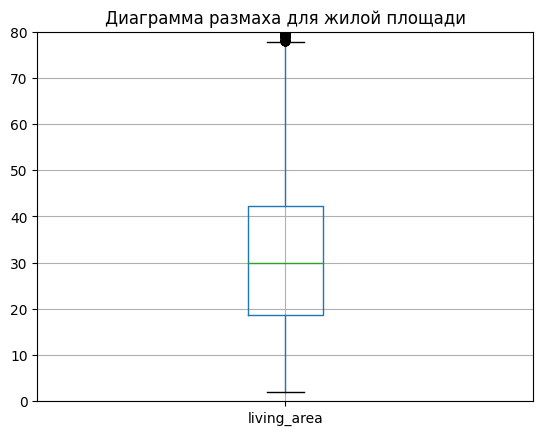

In [40]:
data.boxplot('living_area')
plt.title('Диаграмма размаха для жилой площади')
plt.ylim(0, 80)
plt.show()

Среднее значение немногим больше медианы, значит выбивающиеся значения не сильно влияют на данные.

Однако значения выше 80 предлагаю выделить как слишком большие жилые пространства.


Создадим столбец ['normal_living_area'], где значение True будет для площадей до 80 кв м.

In [41]:
data['normal_living_area'] = data['living_area'] < 80

In [42]:
data['normal_total_area'].value_counts()

True     22474
False     1091
Name: normal_total_area, dtype: int64

Наблюдаем два пика (около 18 кв м и 30), значит большинство квартир в объявления студии и однушки, далее это проверим.
Так же заметен резкий спад в районе 22 кв м, возможно это связано с особенностями планировки квартир.  
Чаще всего продают квартиры с жилой площадью до 80 кв.м.


В данном столбце аномалии не выявлены. Редковстречающиеся значения мы отфильтровали.

##### Площадь кухни

In [43]:
data['kitchen_area'].describe()

count    21343.000000
mean        10.560994
std          5.900630
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

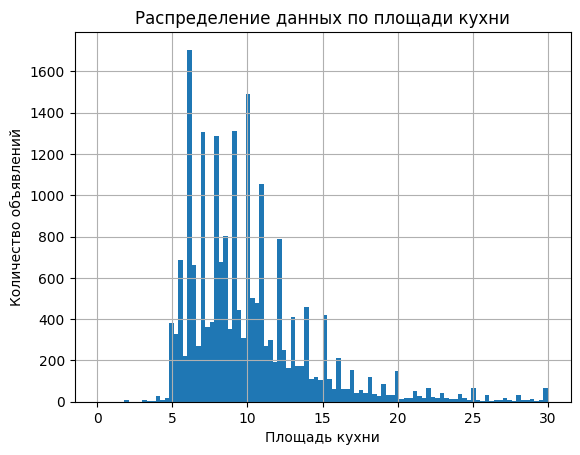

In [44]:
data['kitchen_area'].hist(bins=100, range=(0,30))
plt.title('Распределение данных по площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Количество объявлений')
plt.show()

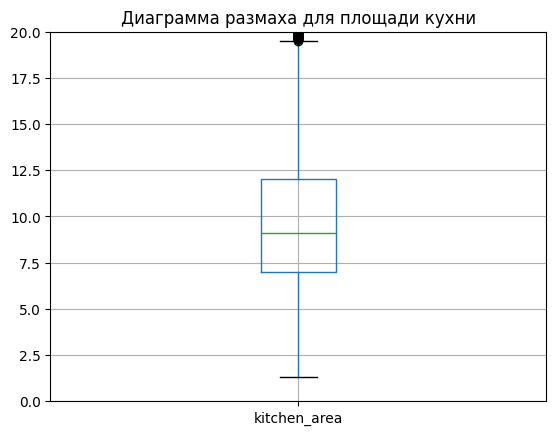

In [45]:
data.boxplot('kitchen_area')
plt.title('Диаграмма размаха для площади кухни')
plt.ylim(0, 20)
plt.show()

Среднее значение немногим больше медианы, значит выбивающиеся значения не сильно влияют на данные.

Однако значения выше 20 предлагаю выделить как слишком большие кухни.


Создадим столбец ['normal_kitchen_area'], где значение True будет для площадей до 20 кв м.

In [46]:
data['normal_kitchen_area'] = data['kitchen_area'] < 20

In [47]:
data['normal_kitchen_area'].value_counts()

True     20192
False     3373
Name: normal_kitchen_area, dtype: int64

Наблюдаем равномерное заспределение значений по целым числам, самый большой пик на 6 и 10, после заметен спад. 
Крайние значения также малочислены, их не меняем.

Чаще всего продают квартиры с площадью кухни до 20 кв.м.


Редковстречающиеся значения мы отфильтровали.

##### Цена объекта 

In [48]:
data['last_price'].describe()

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Для удобства приведем столбец к тысячам и отразим это в названии столбца

In [49]:
data['last_price'] = (data['last_price']/1000*1.0).round()

In [50]:
data.rename(columns={'last_price': 'last_price_1000'}, inplace=True)
data['last_price_1000'].describe()

count     23565.000000
mean       6540.058307
std       10910.934358
min          12.000000
25%        3400.000000
50%        4646.000000
75%        6790.000000
max      763000.000000
Name: last_price_1000, dtype: float64

Построим диаграмму размаха с ограничением цены 50 млн руб

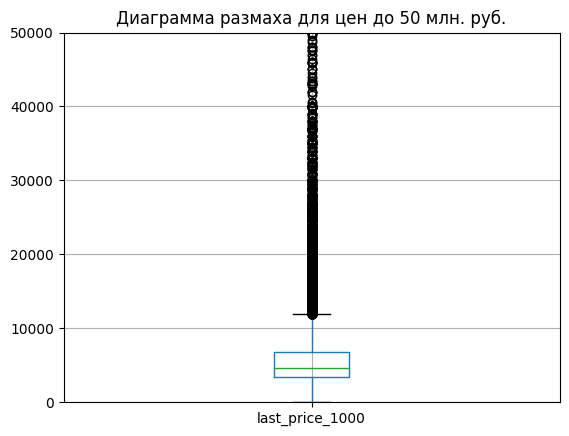

In [51]:
data.boxplot('last_price_1000')
plt.title('Диаграмма размаха для цен до 50 млн. руб.')
plt.ylim(0, 50000.000000)
plt.show()

Верхний 'ус' находится в районе 12 млн руб. 

Построим гистограмму с тем же ограничением цены 12 млн руб

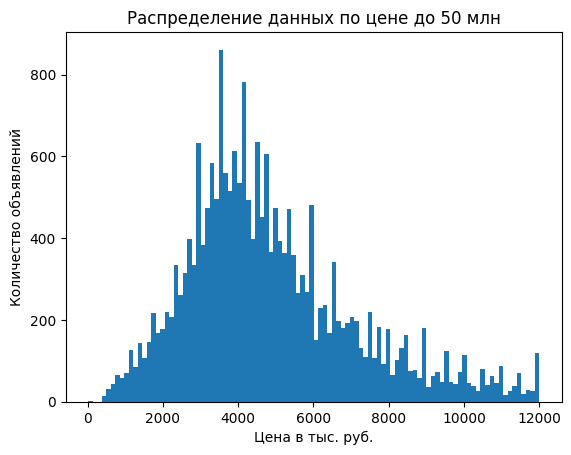

In [52]:
plt.hist(data['last_price_1000'], bins=100, range=(12.000000,12000.000000))
plt.title('Распределение данных по цене до 50 млн')
plt.xlabel('Цена в тыс. руб.')
plt.ylabel('Количество объявлений')
plt.show()

Исходя из вышеизложенного значения выше 12 млн предлагаю выделить в категорию "дорогие"

Создадим столбец normal_price_1000 в котором значениями True будут цены ниже 12 млн руб, а выше False.

In [53]:
data['normal_price_1000'] = data['last_price_1000'] < 120000.000000

In [54]:
data['normal_price_1000'].value_counts()

True     23531
False       34
Name: normal_price_1000, dtype: int64

Посмотрим как изменились среднее значение и медиана.


Для этого создадим переменную и выведем описание значений на экран

In [55]:
data_good_price = data.query('last_price_1000 < 12000.000000')
data_good_price['last_price_1000'].describe()

count    21582.000000
mean      4857.852470
std       2245.491172
min         12.000000
25%       3300.000000
50%       4400.000000
75%       6000.000000
max      11999.000000
Name: last_price_1000, dtype: float64

Мы можем наблюдать несколько пиковых значений в диапазоне от 3 до 6 млн руб.

Чаще всего в объявлениях встречается цена до 12 млн руб.

Редковстречающиеся значения мы отфильтровали.

##### Количество комнат

In [56]:
data['rooms'].describe()

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

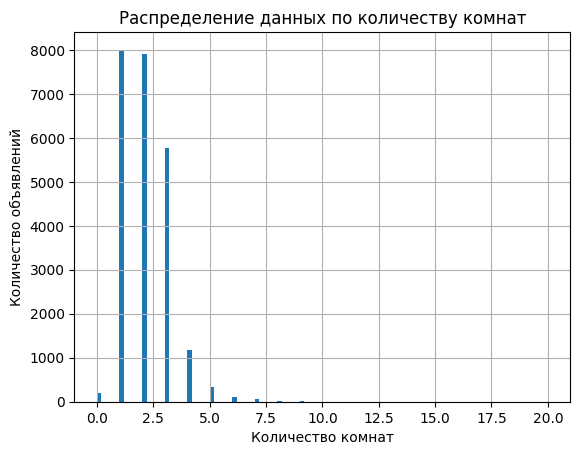

In [57]:
data['rooms'].hist(bins=100, range=(0,20))
plt.title('Распределение данных по количеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объявлений')
plt.show()

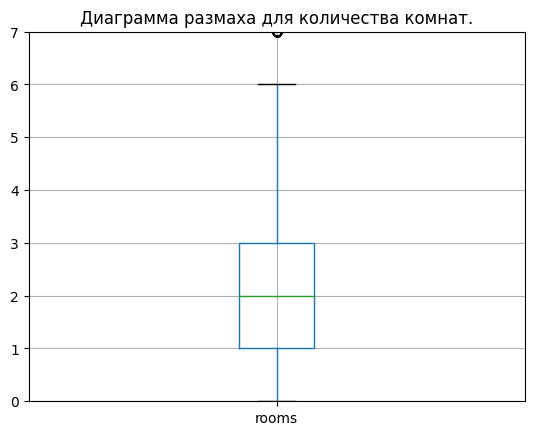

In [58]:
data.boxplot('rooms')
plt.title('Диаграмма размаха для количества комнат.')
plt.ylim(0, 7)
plt.show()

Создадим столбец normal_rooms в котором True будет для значений ниже 6 комнат, а выше False.

In [59]:
data['normal_rooms'] = data['rooms'] < 6

In [60]:
data['normal_rooms'].value_counts()

True     23371
False      194
Name: normal_rooms, dtype: int64

Пики в гистограмме приходят на значения 1, 2, 3 и 4 комнат. Больше всего продают квартиры, в которых меньше 6 комнат.

Значения больше 6 комнат мы отфильтровали как редковстречающиеся.


##### Высота потолков

In [61]:
data['ceiling_height'].describe()

count    23565.000000
mean         2.700373
std          0.306280
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         22.600000
Name: ceiling_height, dtype: float64

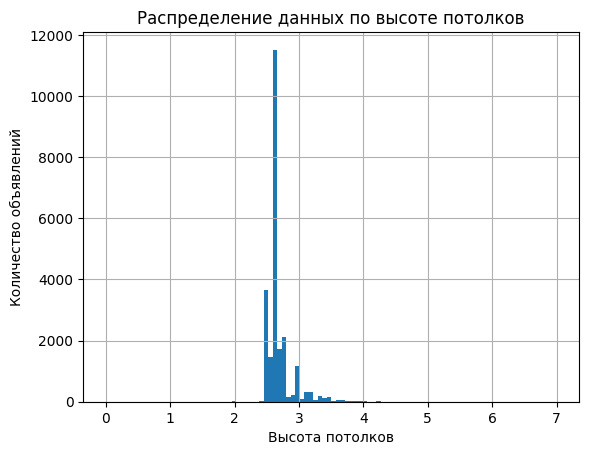

In [62]:
data['ceiling_height'].hist(bins=100, range=(0,7))
plt.title('Распределение данных по высоте потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Количество объявлений')
plt.show()

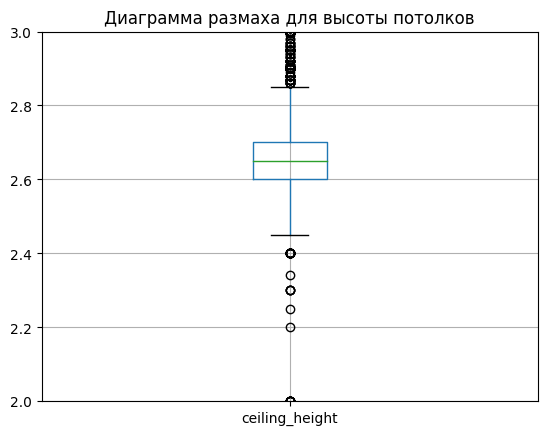

In [63]:
data.boxplot('ceiling_height')
plt.title('Диаграмма размаха для высоты потолков')
plt.ylim(2, 3)
plt.show()

По нормам высота потолков не должна быть ниже 2,65 м. 

Значения потолков ниже 2 м и больше 6 м вызывают сомнения. Врядли такие квартиры существуют, больше похоже на выбросы.
Предлагаю удалить эти данные.

In [64]:
strange_height = (data['ceiling_height'] < 2.5) | (data['ceiling_height'] > 6)
data.drop(data.index[strange_height], inplace=True)

In [65]:
#проверим значения
data['ceiling_height'].describe()

count    23482.000000
mean         2.697988
std          0.220752
min          2.500000
25%          2.600000
50%          2.650000
75%          2.700000
max          6.000000
Name: ceiling_height, dtype: float64

Пики в гистограмме приходят на значения между 2,5 и 2,8. Больше всего продают квартиры, в которых высота потолков до 3 метров.

Мы выявили и удалили аномальные значения для высот ниже 2 метров и выше 6 метров.


##### Тип этажа квартиры 

In [66]:
data['type_floor'].value_counts()

другой       17275
последний     3313
первый        2894
Name: type_floor, dtype: int64

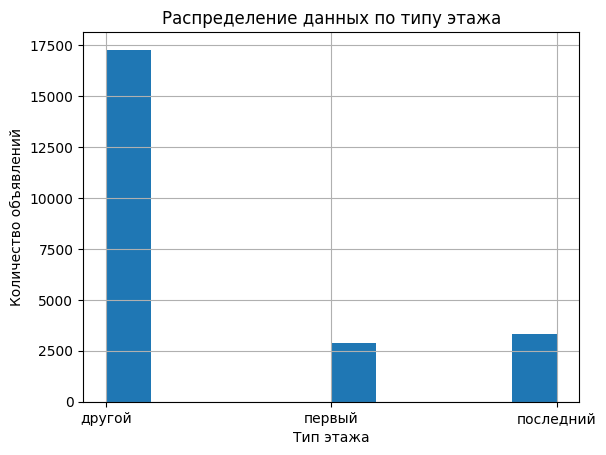

In [67]:
data['type_floor'].hist()
plt.title('Распределение данных по типу этажа')
plt.xlabel('Тип этажа')
plt.ylabel('Количество объявлений')
plt.show()

Распределение между типами этажей выглядит логичным. 
Больше всего объявлений квартир, которые не находятся на первых и последних этажах.

Эти значения оставляем как есть.

##### Общее количество этажей в доме

In [68]:
data['floors_total'].describe()

count    23482.000000
mean        10.685376
std          6.597087
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

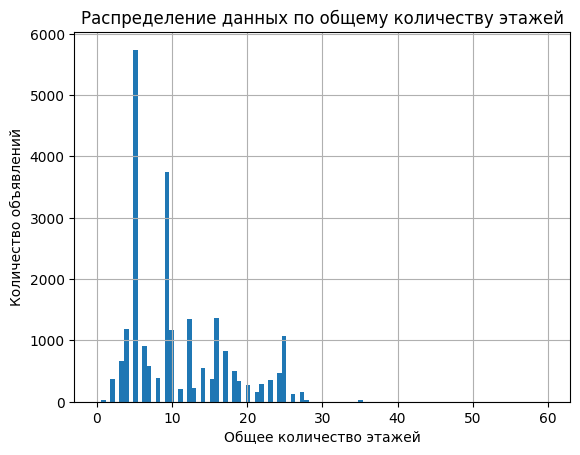

In [69]:
data['floors_total'].hist(bins=100, range=(0,60))
plt.title('Распределение данных по общему количеству этажей')
plt.xlabel('Общее количество этажей')
plt.ylabel('Количество объявлений')
plt.show()

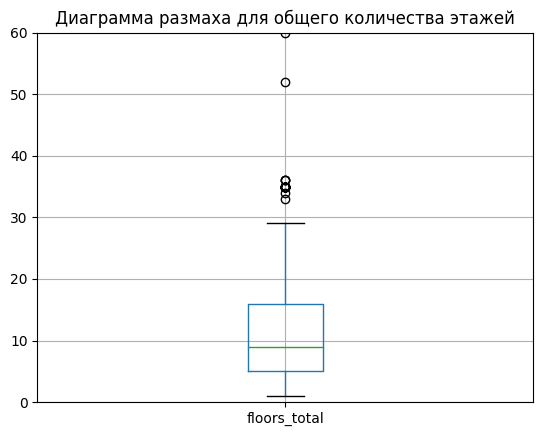

In [70]:
data.boxplot('floors_total')
plt.title('Диаграмма размаха для общего количества этажей')
plt.ylim(0, 60)
plt.show()

Чаще всего в объявлениях встречаютяся объекты в зданиях до 30 этажей.
Создадим столбец с типичными данными.

In [71]:
data['normal_floors_total'] = data['floors_total'] < 30

In [72]:
data['normal_floors_total'].value_counts()

True     23451
False       31
Name: normal_floors_total, dtype: int64

Чаще всего продают квартиры в пяти- и девятиэтажках.
Значения выше 30 этажей встречаются чаще, их мы вывели как редко встречающиеся.

Аномальных значений не выявлено.

##### Расстояние до центра города в метрах

In [73]:
data['city_centers_m'].describe()

count    18013.000000
mean     14189.721312
std       8614.087279
min        181.000000
25%       9238.000000
50%      13095.000000
75%      16285.000000
max      65968.000000
Name: city_centers_m, dtype: float64

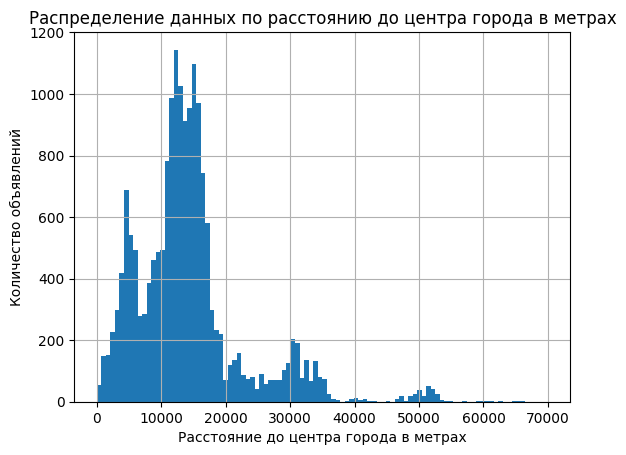

In [74]:
data['city_centers_m'].hist(bins=100, range=(0,70000))
plt.title('Распределение данных по расстоянию до центра города в метрах')
plt.xlabel('Расстояние до центра города в метрах')
plt.ylabel('Количество объявлений')
plt.show()

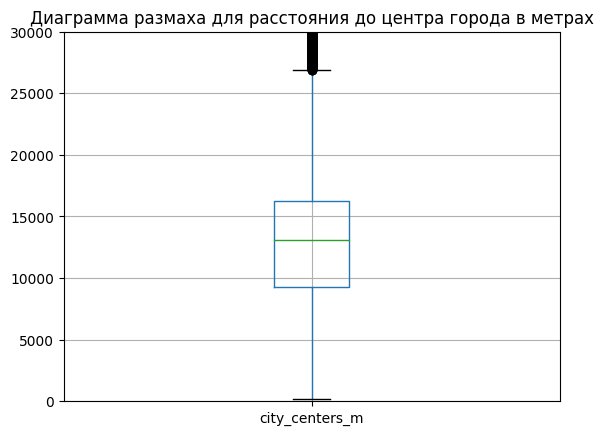

In [75]:
data.boxplot('city_centers_m')
plt.title('Диаграмма размаха для расстояния до центра города в метрах')
plt.ylim(0, 30000)
plt.show()

Посмотрим на распределение расстояния до центра относительно столбца is_spb

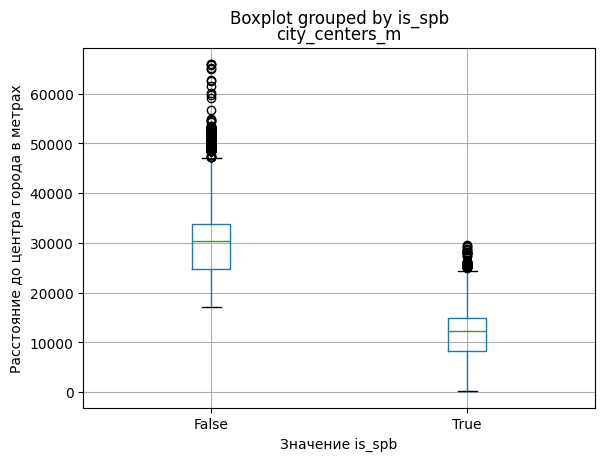

In [76]:
data.boxplot(column='city_centers_m', by='is_spb')
plt.xlabel('Значение is_spb')
plt.ylabel('Расстояние до центра города в метрах')
plt.show()

Заметим как медианные значения по расстоянию до центра для области выше чем для города.

Большинство квартир в объявлениях находятся на расстоянии от центра в диапазоне между 10000 и 20000 м.  
После расстояния 20000 м начинается резкий спад.

В расстояниях мы с уверенностью не сможем выделить аномальные значения.  
Редко встречающиеся большие расстояния тоже предлагаю оставить как есть потому, что их удаление исказит картину для данных из области.

Оставляем данные как есть.

##### Расстояние до ближайшего парка

In [77]:
data['parks_nearest'].describe()

count    7999.000000
mean      490.578447
std       342.058099
min         1.000000
25%       287.500000
50%       454.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

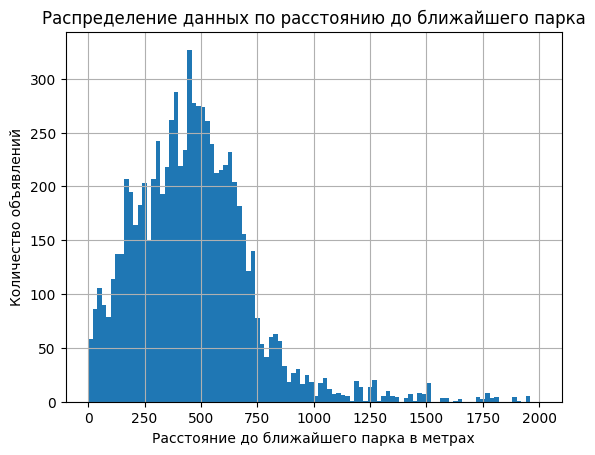

In [78]:
data['parks_nearest'].hist(bins=100, range=(0,2000))
plt.title('Распределение данных по расстоянию до ближайшего парка')
plt.xlabel('Расстояние до ближайшего парка в метрах')
plt.ylabel('Количество объявлений')
plt.show()

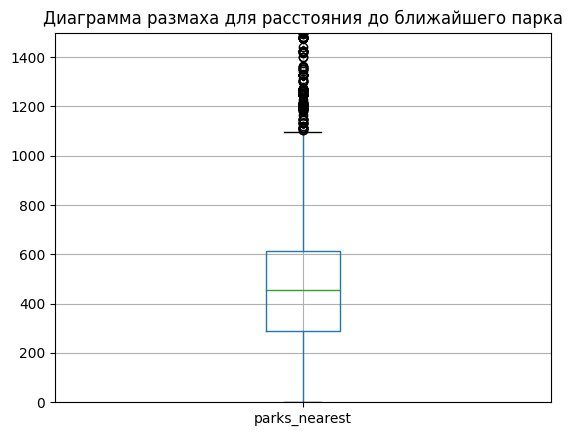

In [79]:
data.boxplot('parks_nearest')
plt.title('Диаграмма размаха для расстояния до ближайшего парка')
plt.ylim(0, 1500)
plt.show()

Медиана и среднее значение не сильно отличаются, крайние значения не сильно влияют на данные.
Большинство квартир в объявлениях находятся на расстоянии от 300 до 600 м до ближайшего парка.  
После расстояния 750 м начинается резкий спад.

В расстояниях мы с уверенностью не сможем выделить аномальные значения.  
Редко встречающиеся большие расстояния тоже предлагаю оставить как есть.


#### Вывод

По результатам изучения параметров можно сделать следующие выводы:  

1. Большинство объявлений содержат информацию о квартирах площадью от 30 до 65 квадратных метров. Квартиры площадью выше 120 квадратных метров встречаются в объявлениях редко.
2. Преобладающими типами квартир являются студии и однокомнатные квартиры, о чем свидетельствует наличие двух пиков в распределении площади жилой площади (около 18 и 30 квадратных метров).
3. Площадь кухни в большинстве объявлений не превышает 20 квадратных метров, что свидетельствует о преобладании компактных планировок.
4. В объявлениях чаще всего указываются цены на квартиры до 12 миллионов рублей.
5. Большинство квартир продаются с количеством комнат меньше 6.
6. Высота потолков в большинстве продаваемых квартирах не превышает 3 метра.
7. Больше всего продаются квартиры, расположенные не на первых и не на последних этажах.
8. Наиболее часто упоминаемыми типами домов являются пяти- и девятиэтажные дома.
9. Большинство квартир в объявлениях находятся на расстоянии от центра в диапазоне между 10000 и 20000 м. 
10. Большинство квартир в объявлениях находятся на расстоянии от 300 до 600 м до ближайшего парка.

Следует отметить, что в ходе анализа были отфильтрованы редкие и аномальные значения, чтобы улучшить качество данных и обеспечить более точный анализ.

#### Изучение сроков продажи квартир
<a id='Сроки'></a>

In [80]:
data['days_exposition'].describe()

count    20322.000000
mean       180.841354
std        219.928506
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

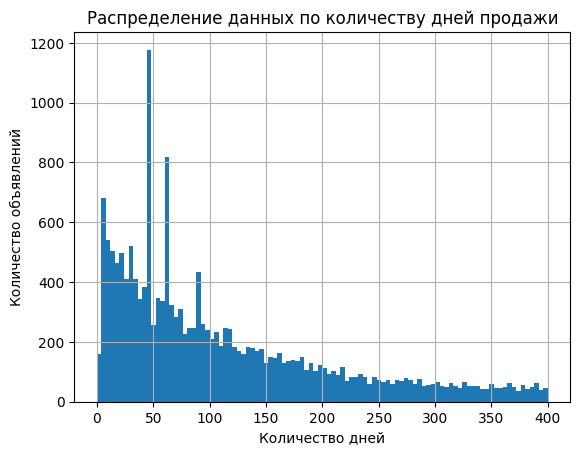

In [81]:
data['days_exposition'].hist(bins=100, range=(0,400))
plt.title('Распределение данных по количеству дней продажи')
plt.xlabel('Количество дней')
plt.ylabel('Количество объявлений')
plt.show()

Мы видим два пика 45 и чуть поменьше 60 дней, а так же небольшой пик 90.

Без этих пиков значения плавно снижаются.
Посмотрим на гистограмму размаха.


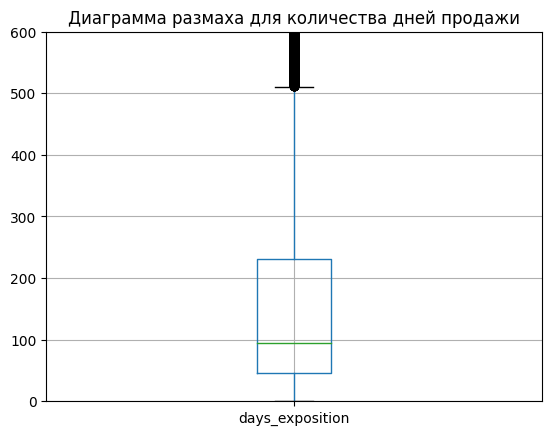

In [82]:
data.boxplot('days_exposition')
plt.title('Диаграмма размаха для количества дней продажи')
plt.ylim(0, 600)
plt.show()

'Усы' распределены неравномерно. 

Создадим функцию для нового столбца, в который войдут следующие категории:  
- меньше 45 дней быстрая продажа
- от 45 до 220 средняя скорость продажи
- от 220 до 500 дней долгая продажа
- от 500 очень долгая продажа

In [83]:
def category_days(row):
    try:
        if row <= 45:
            return 'быстро'
        elif 45 <= row <= 220:
            return 'средне'
        elif 220 <= row <= 500:
            return 'долго'
        elif 200 <= row:
            return 'очень долго'
    except:
        return 'нет данных'
    
data['days_exposition_category'] = data['days_exposition'].apply(category_days)

In [84]:
data['days_exposition_category'].value_counts()

средне         9969
быстро         5057
долго          3561
очень долго    1735
Name: days_exposition_category, dtype: int64

#### Вывод

1. Медианное значение сроков продажи  квартиры не зависит от выбросов и составляет около 3х месяцов.
2. Чаще всего квартиры продаются за период от 45 до 220 дней.
2. Быстрыми продажами можно считать продажи до 45 дней.
3. Долгими продажами можно считать продажи выше 200 дней.
2. Редкими значениями являются сроки продажи превышающие 1 год и 2 месяца.

#### Определение факторов, которые больше всего влияют на общую стоимость объекта
<a id='Факторы'></a>

Изучим, зависит ли цена от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).


Cоздадим датафрейм с нормальными значениями, которые мы создали ранее

In [85]:
data_normal = data[(data['normal_total_area'] == True) & 
     (data['normal_living_area'] == True) &
     (data['normal_kitchen_area'] == True) &
     (data['normal_floors_total'] == True) &
     (data['normal_rooms'] == True) &
     (data['normal_price_1000'] == True)].reset_index(drop=True)

In [86]:
display('Нам удалось сохранить больше {:.1%} от исходных значений!'. format(len(data_normal) / len(data)))

'Нам удалось сохранить больше 81.5% от исходных значений!'

Посмотрим на корреляцию значений

In [87]:
(
display(data_normal.pivot_table(index='total_images', 
        values=['last_price_1000','total_area','living_area','kitchen_area','rooms', 'weekday', 'month', 'year'])
        .corr())
)

,kitchen_area,last_price_1000,living_area,month,rooms,total_area,weekday,year
kitchen_area,1.000000,0.768167,0.424409,0.508264,0.305027,0.610290,0.020307,-0.166310
last_price_1000,0.768167,1.000000,0.737636,0.363572,0.644672,0.820955,0.192262,0.002453
living_area,0.424409,0.737636,1.000000,0.492970,0.978901,0.965942,0.266601,-0.225829
month,0.508264,0.363572,0.492970,1.000000,0.483343,0.516642,0.347892,-0.644147
rooms,0.305027,0.644672,0.978901,0.483343,1.000000,0.906216,0.287406,-0.238859
total_area,0.610290,0.820955,0.965942,0.516642,0.906216,1.000000,0.259156,-0.229636
weekday,0.020307,0.192262,0.266601,0.347892,0.287406,0.259156,1.000000,-0.269023
year,-0.166310,0.002453,-0.225829,-0.644147,-0.238859,-0.229636,-0.269023,1.000000


Посмотрим на зависимость цены от типа этажа

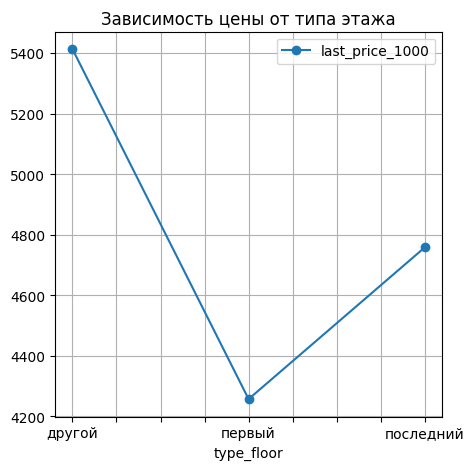

In [88]:
(
    data_normal.pivot_table(index='type_floor', values='last_price_1000')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.title('Зависимость цены от типа этажа')
plt.show()

#### Вывод

Прослеживается зависимость между:  
(ниже список зависимости от большей к меньшей)

- ценой и общей площадью
- ценой и площадью кухни
- ценой и жилой площадью  

Чем больше площадь этих значений, тем выше стоимость.
- ценой и количеством комнат  

Площадь влияет на количество комнат, поэтому увеличение этого параметра так же влечет за собой повышение цены.

Так же на цену влияет тип этажа: самые дешевые квартиры на первом этаже, далее идет последний и самые дорогие на остальных этажах.

С остальными значениями прямой зависимости нет.

#### Cредняя цена одного кв м в 10 населённых пунктах с наибольшим числом объявлений
<a id='Десять'></a>


In [89]:
data_locality_pivot = data.pivot_table('price_sq_meter' , index = ['locality_name'], aggfunc = ['count', 'mean'])
data_locality_pivot.columns = ['count', 'mean']
data_locality_pivot.sort_values('count', ascending=False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,15610,114870.933349
поселок Мурино,552,85629.568641
поселок Шушары,439,78551.344647
Всеволожск,397,68719.320378
Пушкин,366,103147.825574
Колпино,337,75443.972849
поселок Парголово,326,90205.423374
Гатчина,307,68746.146515
деревня Кудрово,299,92473.547559


#### Вывод

Для стоимости цены 1 кв м в 10 населённых пунктах с наибольшим числом объявлений характерны следующие утверждения:


1. Наивысшая цена за 1 квадратный метр в городе Санкт-Петербург, значение ровно 114 870 руб.
2. Далее идет крупный в Ленинградской области город Пушкин со значением 103 147 руб за 1 кв.м.
3. Наименьшими значениями цены являются данные в населенных пунктах Гатчина, Всеволожск и Выборг


#### Вычисление средней стоимости квартир на разном удалении от центра города Санкт-Перербург
<a id='Центр'></a>

Создадим график зависимости цены от удаления от центра города Санкт-Перербург

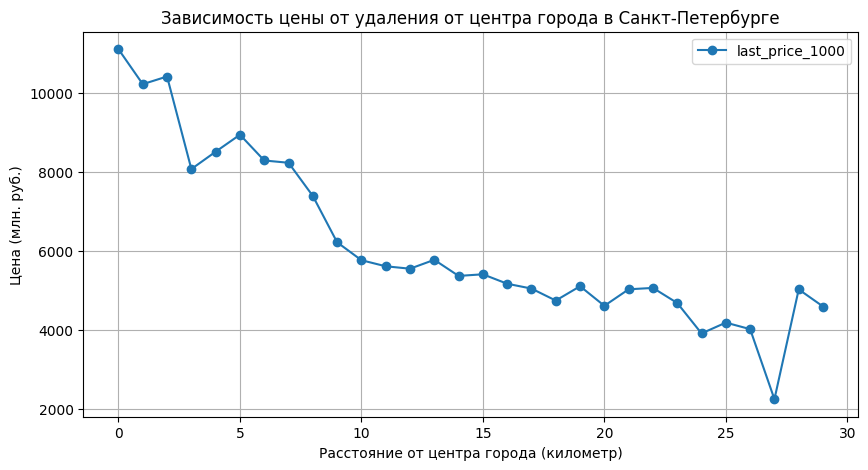

In [90]:
(
    data_normal.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='city_centers_km', values='last_price_1000')
    .plot(grid=True, style='o-', figsize=(10, 5))
)
plt.title('Зависимость цены от удаления от центра города в Санкт-Петербурге')
plt.xlabel('Расстояние от центра города (километр)')
plt.ylabel('Цена (млн. руб.)')
plt.show()



Заметна общая тенденция снижения цены относительно удаленности объектов от центра города с двумя отрицательными пиками.

Посмотрим на изменения средней цены для каждого километра от центра Петербурга

In [91]:
(
    data_normal.query('locality_name == "Санкт-Петербург" and city_centers_km<10')
    .pivot_table(values='last_price_1000', index='city_centers_km')
)

,last_price_1000
city_centers_km,
0.0,11098.000000
1.0,10214.859813
2.0,10408.347059
3.0,8068.564220
4.0,8507.297968
5.0,8936.820034
6.0,8285.389474
7.0,8227.595819
8.0,7388.380734


#### Вывод

Заметна прямая зависимость: чем ближе квартира к центру, тем выше ее стоимость.

1. Самые дорогие квартиры находятся на расстоянии до 2х километров (включительно) от центра города.
3. Начиная с 3х км заметен спад в цене и до 7 км остается на одном уровне.
3. Цена падает для квартир находящихся на расстоянии в 8 км от центра и более.

### Общий вывод

В ходе исследования была проделана следующая работа и составлены выводы:

1. Изучена общая информация о данных

  -  Объем исследуемого датасета насчитывает 23 699 записей и 22 параметра, что вполне достаточно для качественного исследования. Данные представлены в разных форматах (числовых, логических и текстовых значениях). Анализ данных выявил наличие выбросов и некоторого количества пропусков. Обнаружено, что пропущенные данные, которые трудно восполнить достоверной информацией, не будут препятствовать проведению исследования. Другие пропущенные значения можно заместить или удалить без утраты критически важной информации.  
  
  
2. Выполнена предобработка данных

  - изменили тип данных, где это необходимо
  - заменили пропущенные значения, на подходящие там, где это возможно
  - удалили неявные дубликаты в столбце с названием населенного пункта
  - добавили новый столбец, разделяющий квартиры из Санкт-Петербурга и ЛО
  - исправили аномальные значения в столбце с высотой потолков  
   
   
3. Добавили новые столбцы для дальнейшего исследования

  - цена за один квадратный метр
  - день недели публикации
  - месяц публикации
  - год публикации
  - тип этажа квартиры
  - расстояние до центра города в километрах  
  
  
4. Проведен исследовательский анализ данных
- Подробно изучены параметры и найдены типичные для большинства данных значения:
    - площадь от 30 до 65 квадратных метров,
    - площадь кухни не больше 20 квадратных метров,
    - цена не больше 12 миллионов рублей,
    - высота потолков не превышает 3 метра,
    - этаж не первый и не последний,
    - пяти- и девятиэтажные дома,
    - расстояние от центра в диапазоне между 10000 и 20000 м, 
    - расстоянии до ближайшего парка от 300 до 600 м.


  - В ходе анализа были отфильтрованы редкие и аномальные значения, чтобы улучшить качество данных и обеспечить более точный анализ.  
  
  
  - Изучено, как быстро продовались квартиры:
     - медианное значение сроков продажи  квартиры не зависит от выбросов и составляет около 3х месяцов.
     - чаще всего квартиры продаются за период от 45 до 220 дней.
     - быстрыми продажами можно считать продажи до 45 дней.
     - долгими продажами можно считать продажи выше 200 дней.
     - редкими значениями являются сроки продажи превышающие 1 год и 2 месяца.
    
    
  - Определены факторы, которые больше всего влияют на общую (полную) стоимость объекта
    - чем больше общая, жилая площадь и площадью кухни, тем выше стоимость,
    - площадь влияет на количество комнат, поэтому увеличение этого параметра так же влечет за собой повышение цены,
    - так же на цену влияет тип этажа: самые дешевые квартиры на первом этаже, далее идет последний и самые дорогие на остальных этажах,
    - с остальными значениями прямой зависимости не выявлено.  
    
    
  - Посчитана средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
    - наивысшая цена за 1 квадратный метр в городе Санкт-Петербург, значение ровно 114 870 руб,
    - далее идет крупный в Ленинградской области город Пушкин со значением 103 147 руб за 1 кв.м,
    - наименьшими значениями цены являются данные в населенных пунктах Гатчина, Всеволожск и Выборг.  
    
    
  - Вычислена средняя стоимость квартиры на разном удалении от центра Санкт-Петербурга
    - Было обнаружено, что самые высокие цены наблюдаются на квартиры, находящиеся на расстоянии до 2 километров от центра,
    - Для квартир, находящихся на расстоянии от 3 до 7 километров от центра, наблюдается снижение стоимости,
    - Далее, для квартир, находящихся на расстоянии более 8 километров от центра, отмечается самое значительное снижение стоимости.